# Part-of-speech Tagger con Keras

In [27]:
import keras
from keras.preprocessing import text

import numpy as np
import pickle
import pandas as pd

from collections import Counter

In [62]:
import string
def removeLower(tag):
    t = tag.translate(None,string.ascii_lowercase)
    t = t.translate(None,string.digits)
    return t
removeLower("Asd12")

'A'

In [180]:
# Apriamo il file del postagger con pandas
data = pd.read_table("PoSTaggingCorpus/train", sep="\s*")
#visualizziamo il risultato
#print textfile.words
#texfile.tags
words = list(set(data.words))
n_words = len(words)
tags = list(set([removeLower(t) for t in data.tags]))
n_tags = len(tags)

print "#words:",n_words,"#tags:",n_tags
words.append("<PADDING>")
print words[-1]
#print sorted(tags)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


#words: 17314 #tags: 38
<PADDING>


In [64]:
txt = open("PoSTaggingCorpus/train","r")
txt.readline()
txt.readline()
line = txt.readline()
sentences = []
sn = []
while line:
    if line == "\n":
       # print "LINEEND",sn
        sentences.append(sn)
        sn = []
        line = txt.readline()
    else: 
        #print "word"
        ln = line.split("\t")
        ln[1] = ln[1].strip("\n")
        sn.append((ln[0],removeLower(ln[1])))
        line = txt.readline()

print "#sentecses:",len(sentences) 
print sentences[0]

#sentecses: 3719
[('\xc3\x88', 'V'), ('abbastanza', 'B'), ('strano', 'A'), ('il', 'RD'), ('disinteresse', 'S'), ('con', 'E'), ('cui', 'PR'), ('\xc3\xa8', 'VA'), ('stata', 'VA'), ('accolta', 'V'), ("l'", 'RD'), ('intervista', 'S'), ('che', 'PR'), ("l'", 'RD'), ('on.', 'SA'), ('Rino', 'SP'), ('Formica', 'SP'), ('ha', 'VA'), ('dato', 'V'), ('sabato', 'S'), ('scorso', 'A'), ('alla', 'EA'), ('Repubblica', 'SP'), ('.', 'FS')]


In [190]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
print word2idx["<PADDING>"]

tag2idx = {t: i for i, t in enumerate(tags)}
print tag2idx["X"]

17315
32


In [191]:
max_len = 30
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=17315)
# X is the value for the residual class
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["X"])


In [192]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [193]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.05)
X_te.shape

(186, 30)

In [194]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [195]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()
history = None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 30, 20)            346300    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 30, 100)           28400     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 50)            5050      
_________________________________________________________________
crf_9 (CRF)                  (None, 30, 38)            3458      
Total params: 383,208
Trainable params: 383,208
Non-trainable params: 0
_________________________________________________________________


In [196]:
History = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)
if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])

Train on 3179 samples, validate on 354 samples
Epoch 1/5
3179/3179 [==============================] - 13s - loss: 2.4697 - viterbi_acc: 0.3234 - val_loss: 2.0974 - val_viterbi_acc: 0.3732
Epoch 2/5
3179/3179 [==============================] - 11s - loss: 1.8287 - viterbi_acc: 0.4565 - val_loss: 1.4865 - val_viterbi_acc: 0.5581
Epoch 3/5
3179/3179 [==============================] - 11s - loss: 1.1673 - viterbi_acc: 0.6465 - val_loss: 0.9205 - val_viterbi_acc: 0.7121
Epoch 4/5
3179/3179 [==============================] - 11s - loss: 0.7260 - viterbi_acc: 0.7770 - val_loss: 0.6002 - val_viterbi_acc: 0.8074
Epoch 5/5
3179/3179 [==============================] - 11s - loss: 0.4748 - viterbi_acc: 0.8584 - val_loss: 0.4307 - val_viterbi_acc: 0.8745


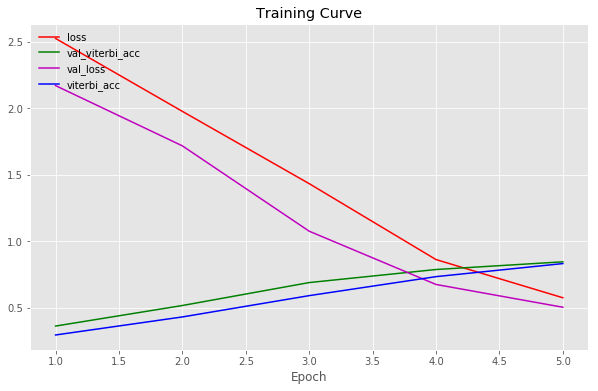

In [187]:
def plot_traincurve(history):
    # define 4 colors for up to 4 different values in history
    colors = {'loss':'r', 'viterbi_acc':'b', 'val_loss':'m', 'val_viterbi_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")


    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)
    
plot_traincurve(history)


In [188]:
def acc_score(pred, test):
    r = 0.0
    c = 0
    for i,p in enumerate(pred):
        if p == test[i]:
            c += 1.0
    print c,"out of",len(pred)
    return c / len(pred)

In [189]:
def testSentence(i, verbose=False):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)

    if verbose:
        print p,true
        print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
        print(30 * "=")
        for w, t, pred in zip(X_te[i], true, p[0]):
            if w != 0:
                print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))
    
    return acc_score(p[0],true)

testSentence(0, True)

[[13 28 22 30 36 28 20 30 24 28 30 22 30 21 36  4 36 30 28 21 22 36 28 19
  30 19  4  0 32 32]] [13 28 22 30 36 28 20 20 24 28 30 22 34 21 22  4 36 12 28 21 22 36 28 22 26
 28  4  0 32 32]
Word           ||True ||Pred
La             : RD    RD
decisione      : S     S
di             : E     E
cominciare     : V     V
un             : RI    RI
dialogo        : S     S
è             : VA    VA
stata          : VA    V
del            : EA    EA
resto          : S     S
definita       : V     V
da             : E     E
Shultz         : SP    V
solo           : B     B
come           : E     RI
«             : FB    FB
un             : RI    RI
primo          : NO    V
passo          : S     S
avanti         : B     B
in             : E     E
un             : RI    RI
cammino        : S     S
lungo          : E     A
mille          : N     V
miglia         : S     A
»             : FB    FB
.              : FS    FS
cineclub       : X     X
cineclub       : X     X
23.0 out of 30


0.7666666666666667

In [94]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


array = confusion_matrix(y_te, test_pred)
array = preprocessing.normalize(array, axis=1, norm='l1')
df_cm = pd.DataFrame(array, index = [i for i in genres],
                  columns = [i for i in genres])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="magma")

NameError: name 'test_labels' is not defined

In [121]:
y_te[1][0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])